In [31]:
import torch
import sys
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [35]:
sys.path.append(str(Path.cwd().parents[1] / "src"))
from preprocessing.preprocess_dataset import DistilBertPreprocessor
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# CONFIGURATION
CHECKPOINT_PATH = Path.cwd().parents[1] / "models" / "distilbert"
DATA_DIR = Path("/Volumes/MACBACKUP/final_datasets/")
TEST_DATA_PATH = DATA_DIR / "final_test_dataset.csv"

In [29]:
def main():
    # LOAD SAVED MODEL AND TOKENIZER
    print(f"Loading model and tokenizer from {CHECKPOINT_PATH}...")
    if not CHECKPOINT_PATH.exists():
        print("Error: Model checkpoint not found. Please train the model first.")
        return
        
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT_PATH)
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_PATH)
    model.to(device)
    model.eval()

    # LOADING AND PREPROCESSING TEST DATA
    preprocessor = DistilBertPreprocessor()
    
    print("Loading and preprocessing test data...")
    # keep_id_column must be True to track participants
    X_test_df, y_test_df = preprocessor.load_and_preprocess(TEST_DATA_PATH, keep_id_column=True)

    # Chunking the test data just like the training data
    X_test_chunked, y_test_chunked = preprocessor.chunk_dataframe(X_test_df, y_test_df)

    # Getting PREDICTIONS FOR EACH CHUNK
    chunk_predictions = []
    print("Getting predictions for each text chunk...")
    with torch.no_grad():
        for index, row in tqdm(X_test_chunked.iterrows(), total=len(X_test_chunked)):
            text = row['text']
            participant_id = row['participant_id']
            
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            outputs = model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=-1).item()
            
            chunk_predictions.append({
                'participant_id': participant_id,
                'chunk_prediction': prediction
            })
    
    chunk_results_df = pd.DataFrame(chunk_predictions)

    # AGGREGATING PREDICTIONS (MAJORITY VOTING)
    print("Aggregating chunk predictions to participant level...")
    final_preds_series = chunk_results_df.groupby('participant_id')['chunk_prediction'].agg(lambda x: x.mode()[0])
    final_preds_df = final_preds_series.reset_index().rename(columns={'chunk_prediction': 'final_prediction'})

    # CALCULATING FINAL METRICS
    print("Calculating final performance metrics...")
    
    # Merge final predictions with the original true labels
    # We use the original y_test_df which has one label per participant
    true_labels_df = X_test_df.join(y_test_df)
    
    results_df = pd.merge(final_preds_df, true_labels_df, on='participant_id')

    true_labels = results_df['label']
    final_predictions = results_df['final_prediction']

    # Generate and print the classification report
    report = classification_report(true_labels, final_predictions, target_names=['Not Depressed (0)', 'Depressed (1)'])
    accuracy = accuracy_score(true_labels, final_predictions)
    
    print("\n" + "="*50)
    print("FINAL TEST SET PERFORMANCE")
    print("="*50)
    print(f"\nOverall Accuracy: {accuracy:.4f}\n")
    print("Classification Report:")
    print(report)
    print("="*50)
    
    cm = confusion_matrix(true_labels, final_predictions)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Depressed (0)', 'Depressed (1)'],
            yticklabels=['Not Depressed (0)', 'Depressed (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Loading model and tokenizer from /Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/models/distilbert...


/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1723 > 512). Running this sequence through the model will result in indexing errors


Loading and preprocessing test data...
Successfully loaded /Volumes/MACBACKUP/final_datasets/final_test_dataset.csv. Found 47 records.
Text cleaning complete.
Data prepared. X shape: (47, 2), y shape: (47, 1)

Starting chunking with chunk_size=512 and overlap=50...
Chunking complete. Original docs: 47, Total chunks: 206
Getting predictions for each text chunk...


100%|██████████| 206/206 [00:06<00:00, 29.89it/s]


Aggregating chunk predictions to participant level...
Calculating final performance metrics...

FINAL TEST SET PERFORMANCE

Overall Accuracy: 0.6596

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.71      0.88      0.78        33
    Depressed (1)       0.33      0.14      0.20        14

         accuracy                           0.66        47
        macro avg       0.52      0.51      0.49        47
     weighted avg       0.60      0.66      0.61        47



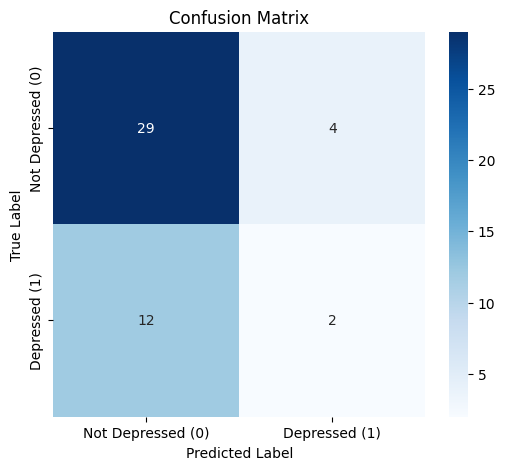

In [36]:
if __name__ == "__main__":
    main()